# A blue book for Bulldozers

![ ](bulldozer.jpg " ")

## Overview

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration. The data is sourced from auction result postings and includes information on usage and equipment configurations.

## Data

For this competition, we are predicting the sale price of bulldozers sold at auctions.

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have. The descriptions all start with "machine configuration" in the data dictionary. Some product types do not have a particular option, so all the records for that option variable will be null for that product type. Also, some sources do not provide good option and/or hours data.

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).


# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import os
import pandas as pd
import numpy as np
import sklearn
import math
import scipy
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from IPython.display import display
from scipy.cluster import hierarchy as hc
from pdpbox import pdp
from plotnine import *

In [3]:
DATA_DIR = "data/"
!ls {DATA_DIR}

Machine_Appendix.csv appendix.frt         df_process_2.frt
Train.csv            df_merge.frt         train.frt
Valid.csv            df_process.frt       train.ftr


# Load data

In [5]:
# %time df_train_raw = pd.read_csv(f"{DATA_DIR}Train.csv", low_memory=False, parse_dates=["saledate"])
# %time df_appendix_raw = pd.read_csv(f"{DATA_DIR}Machine_Appendix.csv", low_memory=False)

CPU times: user 1min 32s, sys: 601 ms, total: 1min 32s
Wall time: 1min 32s
CPU times: user 1.04 s, sys: 102 ms, total: 1.14 s
Wall time: 1.15 s


In [7]:
# df_train_raw.to_feather(f"{DATA_DIR}Train.frt")
# df_appendix_raw.to_feather(f"{DATA_DIR}appendix.frt")

In [46]:
%time df_train_raw = pd.read_feather(f"{DATA_DIR}Train.frt")
%time df_appendix_raw = pd.read_feather(f"{DATA_DIR}appendix.frt")

CPU times: user 647 ms, sys: 259 ms, total: 906 ms
Wall time: 905 ms
CPU times: user 280 ms, sys: 89.3 ms, total: 370 ms
Wall time: 368 ms


In [47]:
# We merge the two dataframes by the MachineID key
# df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")
print(df_train_raw.columns)
print(df_appendix_raw.columns)

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')
Index(['MachineID', 'ModelID', 'fiModelDesc', 'fiBaseM

In [48]:
# Merge the two dataframes on the key MachineID, we'll deal after with the duplicate columns fiModelDesc, ...
df_merge_raw = pd.merge(df_train_raw, df_appendix_raw, on="MachineID", how="inner")

In [49]:
df_merge_raw.to_feather(f"{DATA_DIR}merge_raw.frt")

In [50]:
df_merge_raw = pd.read_feather(f"{DATA_DIR}merge_raw.frt")

In [51]:
# Save memory by deleting the two originals dataframes
del df_train_raw
del df_appendix_raw

In [52]:
# Now let deal with the duplicate columns
df_merge_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID_x', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc_x', 'fiBaseModel_x', 'fiSecondaryDesc_x',
       'fiModelSeries_x', 'fiModelDescriptor_x', 'ProductSize',
       'fiProductClassDesc_x', 'state', 'ProductGroup_x', 'ProductGroupDesc_x',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'ModelID_y', 'fiModelDesc_y', 'fiBaseModel_y', 'fiSe

In [53]:
# From the files descriptions we can deduce that the values in the appendix file is more correct.
# But let look on the missing values of each duplicate columns.
duplicate_columns = ["fiModelDesc", "fiBaseModel", "fiSecondaryDesc", "fiModelSeries",
                     "fiModelDescriptor", "fiProductClassDesc", "ProductGroup", "ProductGroupDesc", "ModelID"]
temp = {col_name: df_merge_raw[col_name+"_x"].isnull().sum() == df_merge_raw[col_name+"_y"].isnull().sum() for col_name in duplicate_columns}
temp

{'ModelID': True,
 'ProductGroup': True,
 'ProductGroupDesc': True,
 'fiBaseModel': True,
 'fiModelDesc': True,
 'fiModelDescriptor': False,
 'fiModelSeries': False,
 'fiProductClassDesc': True,
 'fiSecondaryDesc': False}

In [54]:
ok_columns = [key for key, val in temp.items() if val == True]
{col_name: [df_merge_raw[col_name+"_x"].isnull().sum(), df_merge_raw[col_name+"_y"].isnull().sum()] for col_name in duplicate_columns}

{'ModelID': [0, 0],
 'ProductGroup': [0, 0],
 'ProductGroupDesc': [0, 0],
 'fiBaseModel': [0, 0],
 'fiModelDesc': [0, 0],
 'fiModelDescriptor': [329206, 326906],
 'fiModelSeries': [344217, 343515],
 'fiProductClassDesc': [0, 0],
 'fiSecondaryDesc': [137191, 135593]}

In [55]:
# We see that their is more missing entries in the columns from the train dataframe than the appendix.
# Hence, for each ducplicate columns we can drop the ones that come from the train dataframe.
df_merge = df_merge_raw.drop([col_name+"_x" for col_name in duplicate_columns], axis=1)

In [60]:
# For convinience we remove the _y of each duplicate columns
for col_name in duplicate_columns:
    df_merge[col_name] = df_merge[col_name+"_y"]
    df_merge.drop(col_name+"_y", axis=1, inplace=True)

In [61]:
# Let save the dataframe
df_merge.to_feather(f"{DATA_DIR}df_merge.frt")

In [63]:
del df_merge_raw

## Missing values

In [64]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge.frt")

In [65]:
def missing_values_stats(df, keep_zeros=False):
    res = pd.DataFrame()
    res["Total"] = df.isnull().sum().sort_values(ascending=False)
    res["Percentage"] = np.round((res["Total"]/len(df))*100, 2)
    if not keep_zeros:
        res = res.loc[res.Total > 0, ["Total", "Percentage"]]
    return res

In [66]:
missing_values_stats(df_merge)

,Total,Percentage
Pushblock,375906,93.71
Tip_Control,375906,93.71
Engine_Horsepower,375906,93.71
Blade_Extension,375906,93.71
Blade_Width,375906,93.71
Enclosure_Type,375906,93.71
Scarifier,375895,93.71
Hydraulics_Flow,357763,89.19
Grouser_Tracks,357763,89.19
Coupler_System,357667,89.17


### Years

In [69]:
# From description MfgYear should be the correct version of YearMade. Let have a look at what their differs.
(df_merge["YearMade"] != df_merge["MfgYear"]).sum()

33864

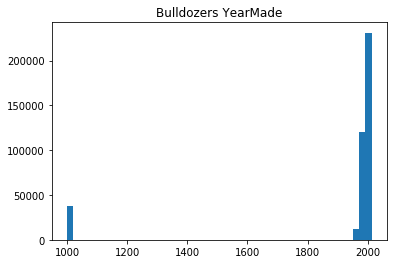

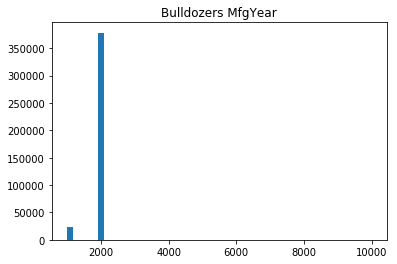

In [75]:
# The two columns have 33864 different entries.
# Before dropping YearMade, let see if some weird values from MfgYear can be correct using YearMade.
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

In [76]:
# Clearly their are some weird values: 
#  - In MfgYear there are some values in the 10000's, we should replace them with the values in YearMade
#  - In both features there are some bulldozers build in the 1000's which is obviously wrong, let see if there are the same in each columns
df_merge[df_merge.MfgYear > 2012]

,SalesID,SalePrice,MachineID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,ProductSize,...,PrimaryUpper,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,ProductGroup,ProductGroupDesc,ModelID
168998,1579170,20500,884218,132,22.0,1996,NaN,None,2009-11-21,Compact,...,1000000.0,848G,848,G,None,None,"Skidder, Wheel - 161.0 + Horsepower",SKID,Skidders,4839


In [77]:
df_merge.loc[df_merge.MfgYear > 2012, "MfgYear"] = 1996

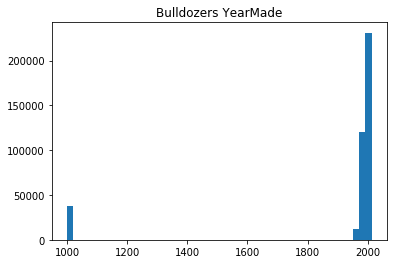

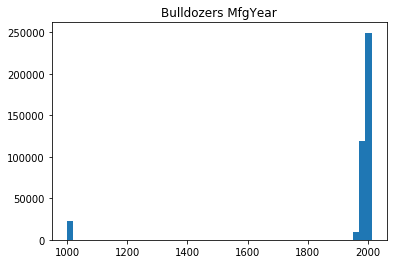

In [78]:
plt.hist(df_merge["YearMade"], bins=50)
plt.title("Bulldozers YearMade")
plt.show()
plt.hist(df_merge["MfgYear"].dropna(), bins=50)
plt.title("Bulldozers MfgYear")
plt.show()

In [79]:
print("YearMade < 1900: ", len(df_merge[df_merge.YearMade < 1900]))
print("MfgYear < 1900: ", len(df_merge[df_merge.MfgYear < 1900]))

YearMade < 1900:  38185
MfgYear < 1900:  22554


In [83]:
MfgYear_idx = df_merge[df_merge.MfgYear < 1900].index
YearMade_idx = df_merge[df_merge.YearMade < 1900].index
[e for e in MfgYear_idx if e not in YearMade_idx]

[]

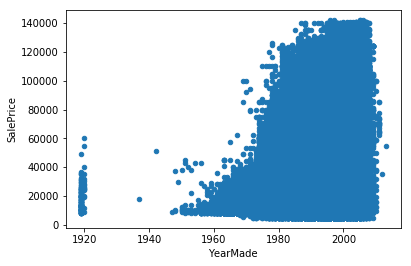

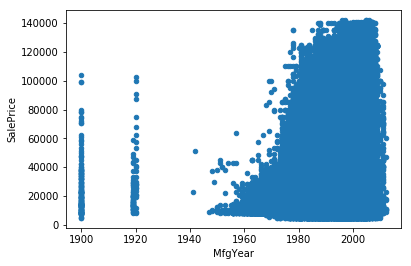

In [87]:
df_merge[df_merge.YearMade >= 1900].plot("YearMade", "SalePrice", "scatter")
plt.show()
df_merge[df_merge.MfgYear >= 1900].plot("MfgYear", "SalePrice", "scatter")

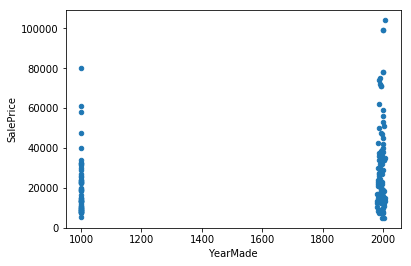

In [93]:
df_merge.iloc[df_merge[df_merge.MfgYear == 1900].index].plot("YearMade", "SalePrice", "scatter")

In [98]:
df_merge["MfgYear_correct"] = df_merge["MfgYear"]

In [117]:
df_merge.loc[df_merge.MfgYear == 1900, "MfgYear_correct"] = df_merge[df_merge.MfgYear == 1900]["YearMade"]

In [130]:
print("values <= 1920:", len(df_merge[df_merge.MfgYear_correct <=1920]), "  ", np.round(len(df_merge[df_merge.MfgYear_correct <=1920])/len(df_merge), 3), "%")

values <= 1920: 22695    0.057 %


In [131]:
dropped_columns = pd.DataFrame()
dropped_columns["YearMade"] = df_merge["YearMade"]
dropped_columns["MfgYear"] = df_merge["MfgYear"]

In [132]:
df_merge.drop(["YearMade", "MfgYear"], axis=1, inplace=True)

In [133]:
df_merge.drop(df_merge[df_merge.MfgYear_correct <= 1920].index, axis=0, inplace=True)

In [134]:
df_merge["MfgYear_correct"].dropna(inplace=True)

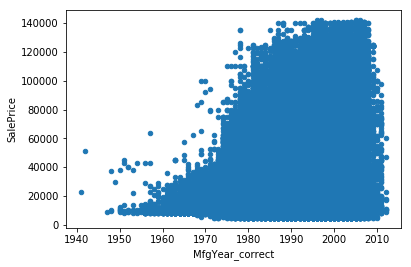

In [135]:
df_merge.plot("MfgYear_correct", "SalePrice", "scatter")

In [140]:
# reset index
df_merge = df_merge.reset_index(drop=True)

In [143]:
df_merge.to_feather(f"{DATA_DIR}df_merge_2.frt")
dropped_columns.to_feather(f"{DATA_DIR}dropped_cols.frt")

In [145]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_2.frt")

### Dates

In [146]:
def date_infos(df_in, col_name, drop=True, inplace=False):
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    # Convert the date column to right dtype if needed
    if not np.issubdtype(df[col_name].dtype, np.datetime64):
        df[col_name] = pd.to_datetime(df[col_name], infer_datetime_format=True)
    new_idx_prefix = re.sub('[Dd]ate$', '', col_name)
    for c in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
              'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[new_idx_prefix+"_"+c] = getattr(df[col_name].dt, c.lower())
    df[new_idx_prefix+'_Elapsed'] = df[col_name].astype(np.int64) // 10**9
    if drop:
        df.drop(col_name, axis=1, inplace=True)
    return df

In [148]:
# Extract all infos from the columns date
df_merge = date_infos(df_merge, "saledate")

In [149]:
df_merge.head()

,SalesID,SalePrice,MachineID,datasource,auctioneerID,MachineHoursCurrentMeter,UsageBand,ProductSize,state,Drive_System,...,sale_Day,sale_Dayofweek,sale_Dayofyear,sale_Is_month_end,sale_Is_month_start,sale_Is_quarter_end,sale_Is_quarter_start,sale_Is_year_end,sale_Is_year_start,sale_Elapsed
0,1139246,66000,999089,121,3.0,68.0,Low,None,Alabama,None,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,57000,117657,121,3.0,4640.0,Low,Medium,North Carolina,None,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,10000,434808,121,3.0,2838.0,High,None,New York,None,...,26,3,57,False,False,False,False,False,False,1077753600
3,1398858,12000,434808,132,2.0,NaN,None,None,Kentucky,None,...,23,4,114,False,False,False,False,False,False,1082678400
4,1398859,12500,434808,132,2.0,NaN,None,None,Texas,None,...,17,2,77,False,False,False,False,False,False,1079481600


### Missing continues values

In [150]:
def fix_numerical_missing_values(df_in, inplace=False):
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_numeric_dtype(col):
            if col.isnull().sum():
                df[col_name+"_na"] = col.isnull()
                df[col_name] = col.fillna(col.dropna().median())
    return df

In [200]:
numerical_features = [col_name for col_name in df_merge.columns if not (pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype))]
categorical_features = [col_name for col_name in df_merge.columns if pd.api.types.is_object_dtype(df_merge[col_name].dtype) or pd.api.types.is_categorical_dtype(df_merge[col_name].dtype)]

In [201]:
numerical_features

['SalesID',
 'SalePrice',
 'datasource',
 'auctioneerID',
 'MachineHoursCurrentMeter',
 'fiManufacturerID',
 'PrimaryLower',
 'PrimaryUpper',
 'MfgYear_correct',
 'sale_Year',
 'sale_Month',
 'sale_Week',
 'sale_Day',
 'sale_Dayofweek',
 'sale_Dayofyear',
 'sale_Is_month_end',
 'sale_Is_month_start',
 'sale_Is_quarter_end',
 'sale_Is_quarter_start',
 'sale_Is_year_end',
 'sale_Is_year_start',
 'sale_Elapsed']

In [202]:
{feat: len(df_merge[feat].unique()) for feat in numerical_features}

{'MachineHoursCurrentMeter': 14939,
 'MfgYear_correct': 69,
 'PrimaryLower': 74,
 'PrimaryUpper': 71,
 'SalePrice': 882,
 'SalesID': 378430,
 'auctioneerID': 31,
 'datasource': 5,
 'fiManufacturerID': 101,
 'sale_Day': 31,
 'sale_Dayofweek': 7,
 'sale_Dayofyear': 360,
 'sale_Elapsed': 3895,
 'sale_Is_month_end': 2,
 'sale_Is_month_start': 2,
 'sale_Is_quarter_end': 2,
 'sale_Is_quarter_start': 2,
 'sale_Is_year_end': 2,
 'sale_Is_year_start': 1,
 'sale_Month': 12,
 'sale_Week': 53,
 'sale_Year': 23}

In [203]:
# Features with ID should be categorical
categorical_features.extend(["MachineID", "ModelID", "SalesID", "auctioneerID", "datasource", "fiManufacturerID"])

In [204]:
for feat in categorical_features:
    df_merge[feat] = df_merge[feat].astype("category")

In [209]:
df_merge = fix_numerical_missing_values(df_merge)

### missing categorical values

In [210]:
{feat: len(df_merge[feat].unique()) for feat in df_merge.columns if pd.api.types.is_categorical(df_merge[feat])}

{'Backhoe_Mounting': 3,
 'Blade_Extension': 3,
 'Blade_Type': 11,
 'Blade_Width': 7,
 'Coupler': 4,
 'Coupler_System': 3,
 'Differential_Type': 5,
 'Drive_System': 5,
 'Enclosure': 7,
 'Enclosure_Type': 4,
 'Engine_Horsepower': 3,
 'Forks': 3,
 'Grouser_Tracks': 3,
 'Grouser_Type': 4,
 'Hydraulics': 13,
 'Hydraulics_Flow': 4,
 'MachineID': 319737,
 'ModelID': 5382,
 'Pad_Type': 5,
 'Pattern_Changer': 4,
 'PrimarySizeBasis': 9,
 'ProductGroup': 39,
 'ProductGroupDesc': 39,
 'ProductSize': 7,
 'Pushblock': 3,
 'Ride_Control': 4,
 'Ripper': 5,
 'SalesID': 378430,
 'Scarifier': 3,
 'Steering_Controls': 6,
 'Stick': 3,
 'Stick_Length': 29,
 'Thumb': 4,
 'Tip_Control': 4,
 'Tire_Size': 18,
 'Track_Type': 3,
 'Transmission': 9,
 'Travel_Controls': 8,
 'Turbocharged': 3,
 'Undercarriage_Pad_Width': 20,
 'UsageBand': 4,
 'auctioneerID': 31,
 'datasource': 5,
 'fiBaseModel': 1992,
 'fiManufacturerDesc': 101,
 'fiManufacturerID': 101,
 'fiModelDesc': 5150,
 'fiModelDescriptor': 153,
 'fiModelSeri

In [240]:
# For each categorical features, if a "None or Unspecified" category exist we replace evry missing values by it
for col_name in df_merge.columns:
    if pd.api.types.is_categorical_dtype(df_merge[col_name]):
        if df_merge[col_name].isnull().sum() > 0 and "None or Unspecified" in df_merge[col_name].unique():
            df_merge[col_name] = df_merge[col_name].fillna("None or Unspecified")            

In [245]:
# Convert categorical features into numericals values
category_mapper = {col_name: {code: idx for code, idx in enumerate(col.cat.categories)} for col_name, col in df_merge.items() if pd.api.types.is_categorical_dtype(col)}

In [248]:
def numericalize(df_in, inplace=False):
    df = pd.DataFrame()
    if inplace:
        df = df_in
    else:
        df = df_in.copy()
    for col_name, col in df.items():
        if pd.api.types.is_categorical_dtype(col):
            df[col_name] = col.cat.codes + 1
    return df


In [249]:
numericalize(df_merge, inplace=True)

,SalesID,SalePrice,MachineID,datasource,auctioneerID,MachineHoursCurrentMeter,UsageBand,ProductSize,state,Drive_System,...,sale_Is_month_start,sale_Is_quarter_end,sale_Is_quarter_start,sale_Is_year_end,sale_Is_year_start,sale_Elapsed,MachineHoursCurrentMeter_na,PrimaryLower_na,PrimaryUpper_na,MfgYear_correct_na
0,1,66000,60614,1,4,68.0,2,0,1,0,...,False,False,False,False,False,1163635200,False,False,False,False
1,2,57000,9310,1,4,4640.0,2,4,33,0,...,False,False,False,False,False,1080259200,False,False,False,False
2,3,10000,27946,1,4,2838.0,1,0,32,0,...,False,False,False,False,False,1077753600,False,False,False,False
3,87598,12000,27946,2,3,0.0,0,0,17,0,...,False,False,False,False,False,1082678400,True,False,False,False
4,87599,12500,27946,2,3,0.0,0,0,44,0,...,False,False,False,False,False,1079481600,True,False,False,False
5,4,38500,66648,1,4,3486.0,1,6,44,0,...,False,False,False,False,False,1305763200,False,False,False,False
6,5,11000,73365,1,4,722.0,3,0,32,0,...,False,False,False,False,False,1248307200,False,False,False,False
7,6,26500,61097,1,4,508.0,2,0,3,2,...,False,False,False,False,False,1229558400,False,False,False,False
8,7,21000,47327,1,4,11540.0,1,3,9,0,...,False,False,False,False,False,1093478400,False,False,False,False
9,10733,29500,47327,1,4,1080.0,2,5,44,0,...,False,False,False,False,False,1156377600,False,False,False,False


In [254]:
df_merge.to_feather(f"{DATA_DIR}df_merge_3.frt")

with open(f"{DATA_DIR}category_mapper", "wb") as handle:
    pickle.dump(category_mapper, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model baseline random forest

In [439]:
df_merge = pd.read_feather(f"{DATA_DIR}df_merge_3.frt")

In [440]:
# We sort the dateframe by saleElapse because sale are time dependant and validation set is the last 2 monts sales
# df_merge = df_merge.sort_values("sale_Elapsed", ascending=False)

In [441]:
sale_price = np.log(df_merge["SalePrice"])

In [442]:
df_merge.drop("SalePrice", axis=1, inplace=True)

In [332]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df_merge)-n_valid
raw_train, raw_valid = split_vals(df_merge, n_trn)
x_train, x_valid = split_vals(df_merge, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((366430, 73), (366430,), (12000, 73))

In [333]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)

%time random_forest.fit(df_merge, sale_price)

CPU times: user 8min 16s, sys: 3.82 s, total: 8min 20s
Wall time: 1min 15s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [411]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(rf):
    score = {"RMSE train": rmse(rf.predict(x_train), y_train), "RMSE valid": rmse(rf.predict(x_valid), y_valid),
             "RF score train": rf.score(x_train, y_train), "RF score valid": rf.score(x_valid, y_valid)}
    if hasattr(rf, "oob_score_"):
        score.update({"RF oob": rf.oob_score_})
    for n, s in score.items():
        print(n+": ", s)
    return score

In [335]:
scores = pd.DataFrame({"baseline": print_score(random_forest)})

RMSE train:  0.07855785473719652
RMSE valid:  0.07980394085239252
RF score train:  0.986958122116
RF score valid:  0.988677126431
RF oob:  0.906875293893


## Features importances

In [336]:
feat_importance = pd.DataFrame({"cols": df_merge.columns, "imp": random_forest.feature_importances_}).sort_values("imp", ascending=False)

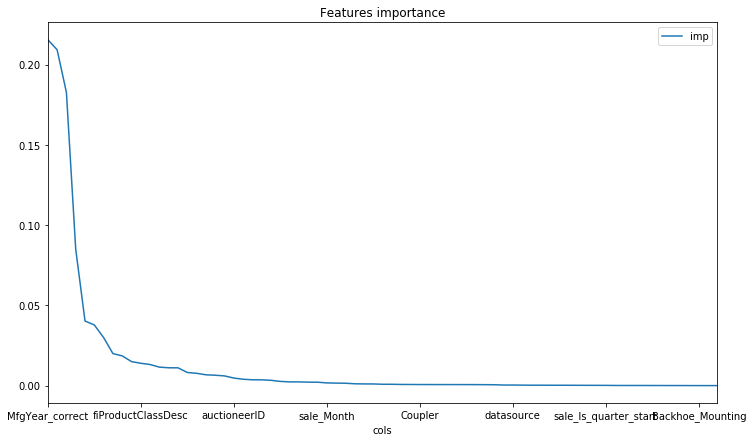

In [337]:
feat_importance.plot("cols", "imp", title="Features importance", figsize=(12,7))

In [338]:
def plot_feat_importance(fi):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7))

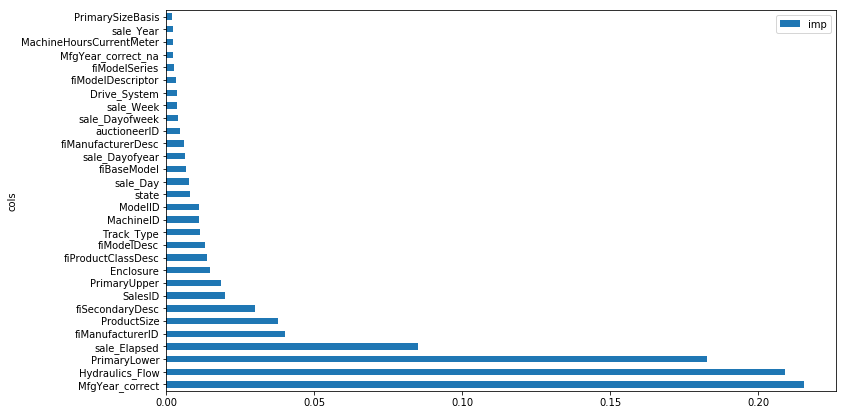

In [339]:
plot_feat_importance(feat_importance[:30])

In [340]:
feat_importance = feat_importance[feat_importance.imp > .005]
len(feat_importance)

20

In [341]:
with open(f"{DATA_DIR}keep_cols", "wb") as handle:
    pickle.dump(feat_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [443]:
df_keep = df_merge[feat_importance.cols]

In [343]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((366430, 20), (366430,), (12000, 20))

In [344]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time random_forest.fit(x_train, y_train)

CPU times: user 4min 35s, sys: 3.16 s, total: 4min 38s
Wall time: 43.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [345]:
scores = scores.join(pd.DataFrame({"feat_importance": print_score(random_forest)}))

RMSE train:  0.080524984835808
RMSE valid:  0.2443356266120051
RF score train:  0.986296793498
RF score valid:  0.89385939125
RF oob:  0.902184081223


In [346]:
scores

,baseline,feat_importance
RF oob,0.906875,0.902184
RF score train,0.986958,0.986297
RF score valid,0.988677,0.893859
RMSE train,0.078558,0.080525
RMSE valid,0.079804,0.244336


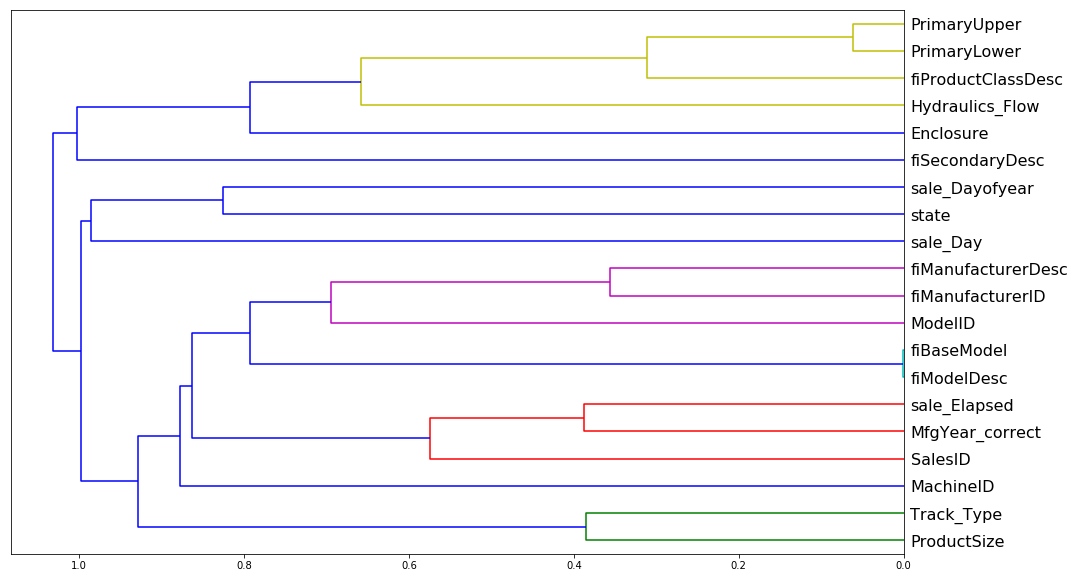

In [347]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [348]:
def get_oob(df):
    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    rf.fit(x, y_train)
    return rf.oob_score_

In [349]:
get_oob(df_keep)

0.90239081414759981

In [350]:
for col_name in ["fiBaseModel", "fiModelDesc"]:
    print(col_name+": ", get_oob(df_keep.drop(col_name, axis=1)))

fiBaseModel:  0.902398247118
fiModelDesc:  0.902328223485


In [444]:
df_keep.drop("fiModelDesc", axis=1, inplace=True)

/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [354]:
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((366430, 19), (366430,), (12000, 19))

In [355]:
%time random_forest.fit(x_train, y_train)

CPU times: user 4min 13s, sys: 2.51 s, total: 4min 16s
Wall time: 40.6 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [356]:
scores = scores.join(pd.DataFrame({"correlation": print_score(random_forest)}))

RMSE train:  0.08013661243827164
RMSE valid:  0.2444317648252595
RF score train:  0.986428656007
RF score valid:  0.893775848983
RF oob:  0.902501105583


In [357]:
scores

,baseline,feat_importance,correlation
RF oob,0.906875,0.902184,0.902501
RF score train,0.986958,0.986297,0.986429
RF score valid,0.988677,0.893859,0.893776
RMSE train,0.078558,0.080525,0.080137
RMSE valid,0.079804,0.244336,0.244432


## Extrapolation

In [445]:
df_keep["age"] = df_merge.sale_Year-df_merge.MfgYear_correct
df_ext = df_keep.copy()
df_ext["is_valid"] = 1
# df_ext = df_ext.loc[:n_trn, "is_valid"] = 0
df_ext["is_valid"].values[:n_trn] = 0
y = df_ext["is_valid"].values
df_ext.drop("is_valid", axis=1, inplace=True)

/Users/bastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [446]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y);
m.oob_score_

0.99671009169463309

In [447]:
fi = pd.DataFrame({"cols": df_ext.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False); fi[:10]

,cols,imp
7,SalesID,0.624775
3,sale_Elapsed,0.146622
12,MachineID,0.112270
4,fiManufacturerID,0.014618
17,sale_Dayofyear,0.014320
0,MfgYear_correct,0.012775
16,fiBaseModel,0.012214
13,ModelID,0.010155
19,age,0.007988
18,fiManufacturerDesc,0.007374


In [448]:
feats=['SalesID', 'sale_Elapsed', 'MachineID']

In [449]:
df_ext.drop(feats, axis=1, inplace=True)

In [450]:
m = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(df_ext, y)
m.oob_score_

0.97681473456121348

In [451]:
fi = pd.DataFrame({"cols": df_ext.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False); fi[:10]

,cols,imp
14,sale_Dayofyear,0.176891
16,age,0.158364
0,MfgYear_correct,0.143998
12,sale_Day,0.102132
11,state,0.087619
10,ModelID,0.067966
13,fiBaseModel,0.049755
3,fiManufacturerID,0.032199
8,fiProductClassDesc,0.030875
2,PrimaryLower,0.029029


In [452]:
feats=['SalesID', 'sale_Elapsed', 'MachineID', 'age', 'sale_Dayofyear', "MfgYear_correct", "sale_Day"]

In [453]:
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [455]:
scores_extra = pd.DataFrame({"baseline": print_score(m, x_train, y_train, x_valid, y_valid)})

RMSE train:  0.08031431532770775
RMSE valid:  0.23954527203242812
RF score train:  0.986368400378
RF score valid:  0.897980500438
RF oob:  0.902662644316


In [415]:
df_subs.shape

(378430, 18)

In [458]:
def print_score(rf, x_train, y_train, x_valid, y_valid):
    score = {"RMSE train": rmse(rf.predict(x_train), y_train), "RMSE valid": rmse(rf.predict(x_valid), y_valid),
             "RF score train": rf.score(x_train, y_train), "RF score valid": rf.score(x_valid, y_valid)}
    if hasattr(rf, "oob_score_"):
        score.update({"RF oob": rf.oob_score_})
    for n, s in score.items():
        print(n+": ", s)
    return score

for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    x_train, x_valid = split_vals(df_subs, n_trn)
    y_train, y_valid = split_vals(sale_price, n_trn)
    m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    m.fit(x_train, y_train)
    scores_extra = scores_extra.join(pd.DataFrame({f: print_score(m, x_train, y_train, x_valid, y_valid)}))
#    print_score(m, x_train, y_train, x_valid, y_valid)

RMSE train:  0.08034342185927516
RMSE valid:  0.2331989189561514
RF score train:  0.986358518193
RF score valid:  0.903314566782
RF oob:  0.902214898376
RMSE train:  0.0820393246289067
RMSE valid:  0.2504429808078703
RF score train:  0.985776546674
RF score valid:  0.888486945937
RF oob:  0.898059194537
RMSE train:  0.07970799508456117
RMSE valid:  0.2392270336306949
RF score train:  0.986573442697
RF score valid:  0.898251388326
RF oob:  0.903554068756
RMSE train:  0.08032489592146205
RMSE valid:  0.244316859112687
RF score train:  0.986364808493
RF score valid:  0.893875696013
RF oob:  0.902003797468
RMSE train:  0.0804902322139591
RMSE valid:  0.24008830946031315
RF score train:  0.986308618886
RF score valid:  0.897517429711
RF oob:  0.901729709483
RMSE train:  0.08039380777001982
RMSE valid:  0.24262608399427008
RF score train:  0.986341402815
RF score valid:  0.895339462859
RF oob:  0.901881602624
RMSE train:  0.08003408876707097
RMSE valid:  0.24295347264351722
RF score train:  

In [459]:
scores_extra

,baseline,SalesID,sale_Elapsed,MachineID,age,sale_Dayofyear,MfgYear_correct,sale_Day
RF oob,0.902663,0.902215,0.898059,0.903554,0.902004,0.901730,0.901882,0.902748
RF score train,0.986368,0.986359,0.985777,0.986573,0.986365,0.986309,0.986341,0.986463
RF score valid,0.897981,0.903315,0.888487,0.898251,0.893876,0.897517,0.895339,0.895057
RMSE train,0.080314,0.080343,0.082039,0.079708,0.080325,0.080490,0.080394,0.080034
RMSE valid,0.239545,0.233199,0.250443,0.239227,0.244317,0.240088,0.242626,0.242953


In [460]:
scores_extra.loc[["RF score valid", "RMSE valid"]].transpose().sort_values("RF score valid", ascending=False)

,RF score valid,RMSE valid
SalesID,0.903315,0.233199
MachineID,0.898251,0.239227
baseline,0.897981,0.239545
sale_Dayofyear,0.897517,0.240088
MfgYear_correct,0.895339,0.242626
sale_Day,0.895057,0.242953
age,0.893876,0.244317
sale_Elapsed,0.888487,0.250443


In [461]:
df_final = df_keep.drop(["SalesID", "MachineID", "sale_Dayofyear", "sale_Day"], axis=1)

In [472]:
x_train, x_valid = split_vals(df_final, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)

CPU times: user 2min 40s, sys: 2.71 s, total: 2min 43s
Wall time: 27.3 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [473]:
# scores.drop("extra", axis=1, inplace=True)
scores = scores.join(pd.DataFrame({"extra": print_score(m, x_train, y_train, x_valid, y_valid)}))

RMSE train:  0.08561430730649974
RMSE valid:  0.22867149598374578
RF score train:  0.984509922399
RF score valid:  0.907032308343
RF oob:  0.903090433084


In [474]:
scores

,baseline,feat_importance,correlation,extra
RF oob,0.906875,0.902184,0.902501,0.903090
RF score train,0.986958,0.986297,0.986429,0.984510
RF score valid,0.988677,0.893859,0.893776,0.907032
RMSE train,0.078558,0.080525,0.080137,0.085614
RMSE valid,0.079804,0.244336,0.244432,0.228671


In [475]:
feat_importance = pd.DataFrame({"cols": df_final.columns, "imp": m.feature_importances_}).sort_values("imp", ascending=False)

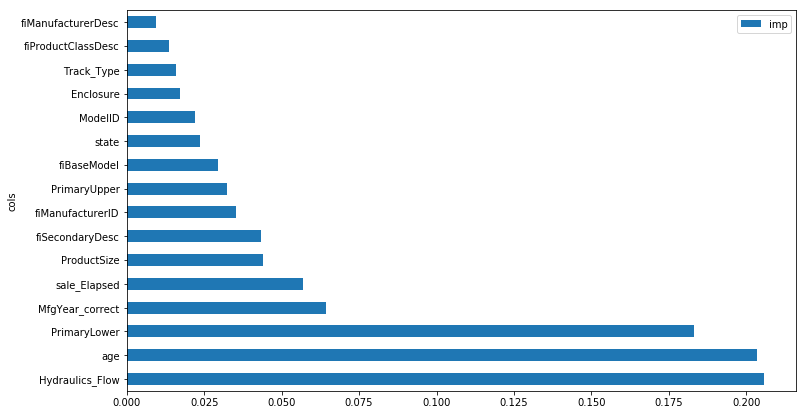

In [476]:
plot_feat_importance(feat_importance[:30])

## confidence on tree variance

In [478]:
%time preds = np.stack([t.predict(x_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 212 ms, sys: 26 ms, total: 238 ms
Wall time: 237 ms


(10.887254871775234, 0.25594433579748516)

## partial dependance

# Features importance

In [315]:
feat_importance = pd.DataFrame({"cols": df_keep.columns, "imp": random_forest.feature_importances_}).sort_values("imp", ascending=False)

ValueError: arrays must all be same length

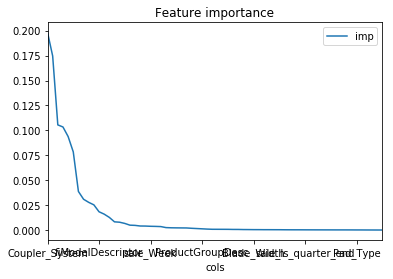

In [166]:
feat_importance.plot("cols", "imp", title="Feature importance")

In [173]:
def plot_feat_importance(fi):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7))

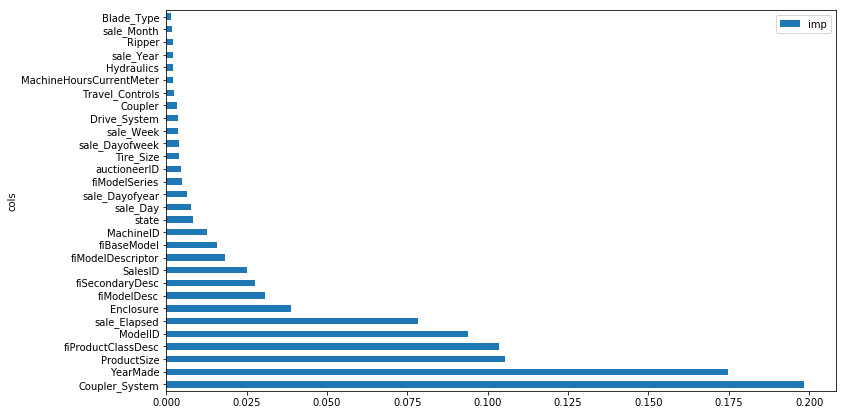

In [174]:
plot_feat_importance(feat_importance[:30])

In [175]:
feat_importance = feat_importance[feat_importance.imp > .005]

In [176]:
len(feat_importance)

16

In [181]:
df_keep = df_process[feat_importance.cols.values]

,Coupler_System,YearMade,ProductSize,fiProductClassDesc,ModelID,sale_Elapsed,Enclosure,fiModelDesc,fiSecondaryDesc,SalesID,fiModelDescriptor,fiBaseModel,MachineID,state,sale_Day,sale_Dayofyear
0,0,2004,0,59,3157,1163635200,3,950,41,1139246,0,296,999089,1,16,320
1,0,1996,4,62,77,1080259200,3,1725,55,1139248,0,527,117657,33,26,86
2,1,2001,0,39,7009,1077753600,6,331,0,1139249,0,110,434808,32,26,57
3,0,2001,6,8,332,1305763200,3,3674,0,1139251,0,1375,1026470,44,19,139
4,1,2007,0,40,17311,1248307200,1,4208,0,1139253,0,1529,1057373,32,23,204


In [219]:
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df_keep)-n_valid
raw_train, raw_valid = split_vals(df_keep, n_trn)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

x_train.shape, y_train.shape, x_valid.shape

((389125, 15), (389125,), (12000, 15))

In [220]:
random_forest = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [223]:
scores = scores.join(pd.DataFrame({"feat_importance": print_score(random_forest)}))

RMSE train:  0.07908663180979683
RMSE valid:  0.2360687745922676
RF score train:  0.986928031702
RF score valid:  0.900476631858
RF oob:  0.906116356966


In [222]:
scores.drop("feat_importance", axis=1, inplace=True)

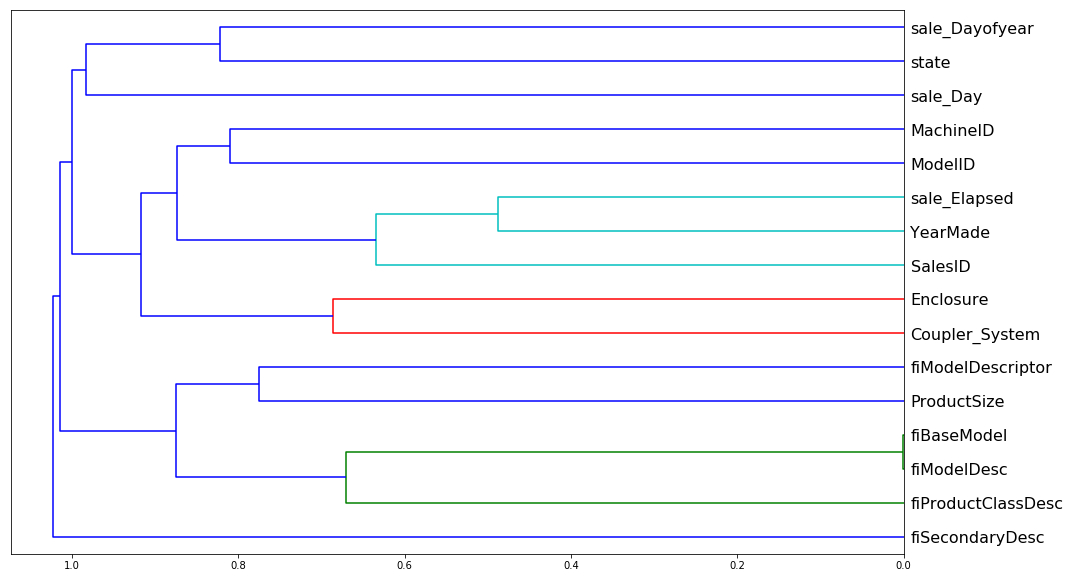

In [206]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [207]:
def get_oob(df):
    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    rf.fit(x, y_train)
    return rf.oob_score_

In [208]:
get_oob(df_keep)

0.90608937954732205

In [209]:
for col_name in ["fiBaseModel", "fiModelDesc"]:
    print(col_name+": ", get_oob(df_keep.drop(col_name, axis=1)))

fiBaseModel:  0.905880599312
fiModelDesc:  0.905719274988


In [212]:
df_keep.head()

,Coupler_System,YearMade,ProductSize,fiProductClassDesc,ModelID,sale_Elapsed,Enclosure,fiModelDesc,fiSecondaryDesc,SalesID,fiModelDescriptor,MachineID,state,sale_Day,sale_Dayofyear
0,0,2004,0,59,3157,1163635200,3,950,41,1139246,0,999089,1,16,320
1,0,1996,4,62,77,1080259200,3,1725,55,1139248,0,117657,33,26,86
2,1,2001,0,39,7009,1077753600,6,331,0,1139249,0,434808,32,26,57
3,0,2001,6,8,332,1305763200,3,3674,0,1139251,0,1026470,44,19,139
4,1,2007,0,40,17311,1248307200,1,4208,0,1139253,0,1057373,32,23,204


In [224]:
random_forest = RandomForestRegressor(n_estimators=150, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
x_train, x_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(sale_price, n_trn)

In [225]:
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [226]:
scores = scores.join(pd.DataFrame({"final": print_score(random_forest)}))

RMSE train:  0.12549459565566543
RMSE valid:  0.22683047951016366
RF score train:  0.967085681048
RF score valid:  0.908113693306
RF oob:  0.91116322676


In [227]:
scores

,baseline,feat_importance,final
RF oob,0.909990,0.906116,0.911163
RF score train,0.987465,0.986928,0.967086
RF score valid,0.900685,0.900477,0.908114
RMSE train,0.077446,0.079087,0.125495
RMSE valid,0.235821,0.236069,0.226830


# Confidence based on tree variance